# TIME SERIES ANALYSIS

### Goal: Find outliers, trends and periodicity in the MTA turnstile data
    

### DATA:
MTA subway fares. It is a complete dataset of
rides logged by card swipes for 600 Manhattan stations.

The data was organized  by Sina Kashuk at CUSP. You can get it in the github repo as well as here: http://cosmo.nyu.edu/~fb55/UI_CUSP_2015/data/MTA_Fare.npy. 

It contains 23 different subway card types 
(e.g. monthly pass, daily pass, Act for Disability pass…) as follows:


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from IPython.display import Image
Image(filename = "Ridetypes.png")

Each time series (per station, per ticket type) contains
the number of swipes per week for 194 weeks 
from 05/21/2010 to 02/21/2014. 

The data are available to you as a python data cube here:

you can load it as 

np.load(“MTA_Fare.npy") and 


you will end up with a python numpy array of 
shape (600,23,194)

##note that the missing values are inputted as -1

if you want to do things like algebra (summing time series for example) you need to take care of that! if you replace the -1 entries with NaN remember to use functions that can deal with nans:
np.nanmean
np.nansum...

In [2]:
mta = np.load("MTA_Fare.npy").astype('float')
mta.shape

(600, 23, 194)

## Task 1: 
### Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series.
### Identify it and figure out what it is due to.

In [3]:
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])

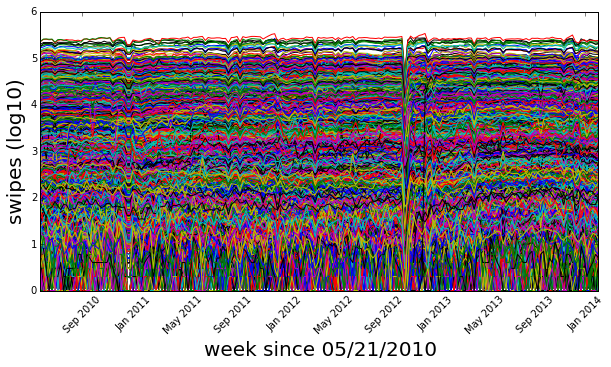

In [4]:
mta[mta == -1] = np.nan
dates = pd.date_range('20100521', periods=194, freq='W')
#print dates
ax1 = plt.figure(figsize = (10,5))
for i in range (0, 600):
    for j in range (0, 23):
        plt.plot(dates, np.log10(mta[i][j]))
plt.xticks(rotation=45)
plt.xlabel("week since 05/21/2010", fontsize = 20)
plt.ylabel("swipes (log10)", fontsize = 20)
#after I create a date range (for example with pd.date_range())
#in a log plot to enhance the visibility along the y axis (np.log10(weightedrides[i]))
#all time series, each station each ride type, look like this (pretty ugly)

#### This plot is messy. Trying to sum the ride counts by station and plot it.

In [5]:
#as described in the instruction for some of the analysis 
#one can sum time series for all stations
mta_allsum_sta = np.nansum(mta, axis=0)
print (mta_allsum_sta.shape)
#or for all ride types
mta_allsum_ridetypes = np.nansum(mta, axis=1)
print (mta_allsum_ridetypes.shape)

(23, 194)
(600, 194)


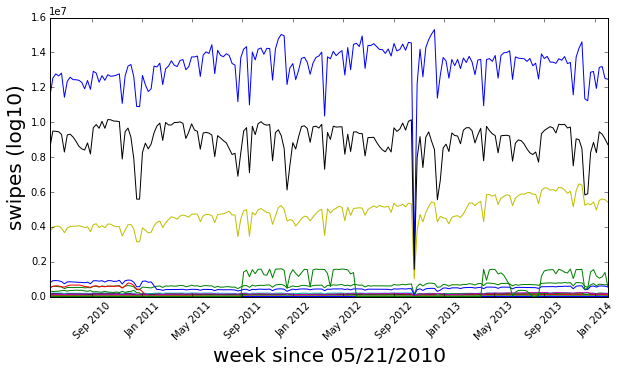

In [16]:
ax2 = plt.figure(figsize = (10,5))
for i in range(0, 23):
    plt.plot(dates, mta_allsum_sta[i])
plt.xticks(rotation=45)
plt.xlabel("week since 05/21/2010", fontsize = 20)
plt.ylabel("swipes (log10)", fontsize = 20)

#### Judgying by the plot above, it seems to be an unusual event happend around Oct/Nov 2012, probably due to Hurricane Sandy.   
#### Now, verifying my assumption:

In [28]:
stadf = pd.DataFrame(data = mta_allsum_sta).dropna().transpose()
stadf.columns = ridetype
stadf.index = dates
#stadf.head()

In [8]:
sumbytype = stadf.sum(axis = 1)
thresholds = [sumbytype.mean() + 3*sumbytype.std(), 
              sumbytype.mean() - 3*sumbytype.std()]
print sumbytype[(sumbytype < thresholds[1]) | (sumbytype > thresholds[0])]

2012-10-21    5218686
Freq: W-SUN, dtype: float64


### It turns out the most prominent event did happen in the week of Oct. 21 2012. Therefore, it was due to the effect from Hurrican Sandy.
***

## Task 2: 
### Some of the time series are stationary, some have a complex structure, some show a downward trend: Identify the **ridership types**  that have steadily increased in popularity,  and that have steadily decreased. by how much? (e.g what is the ratio of usage in the first 10 and last 10 weeks)

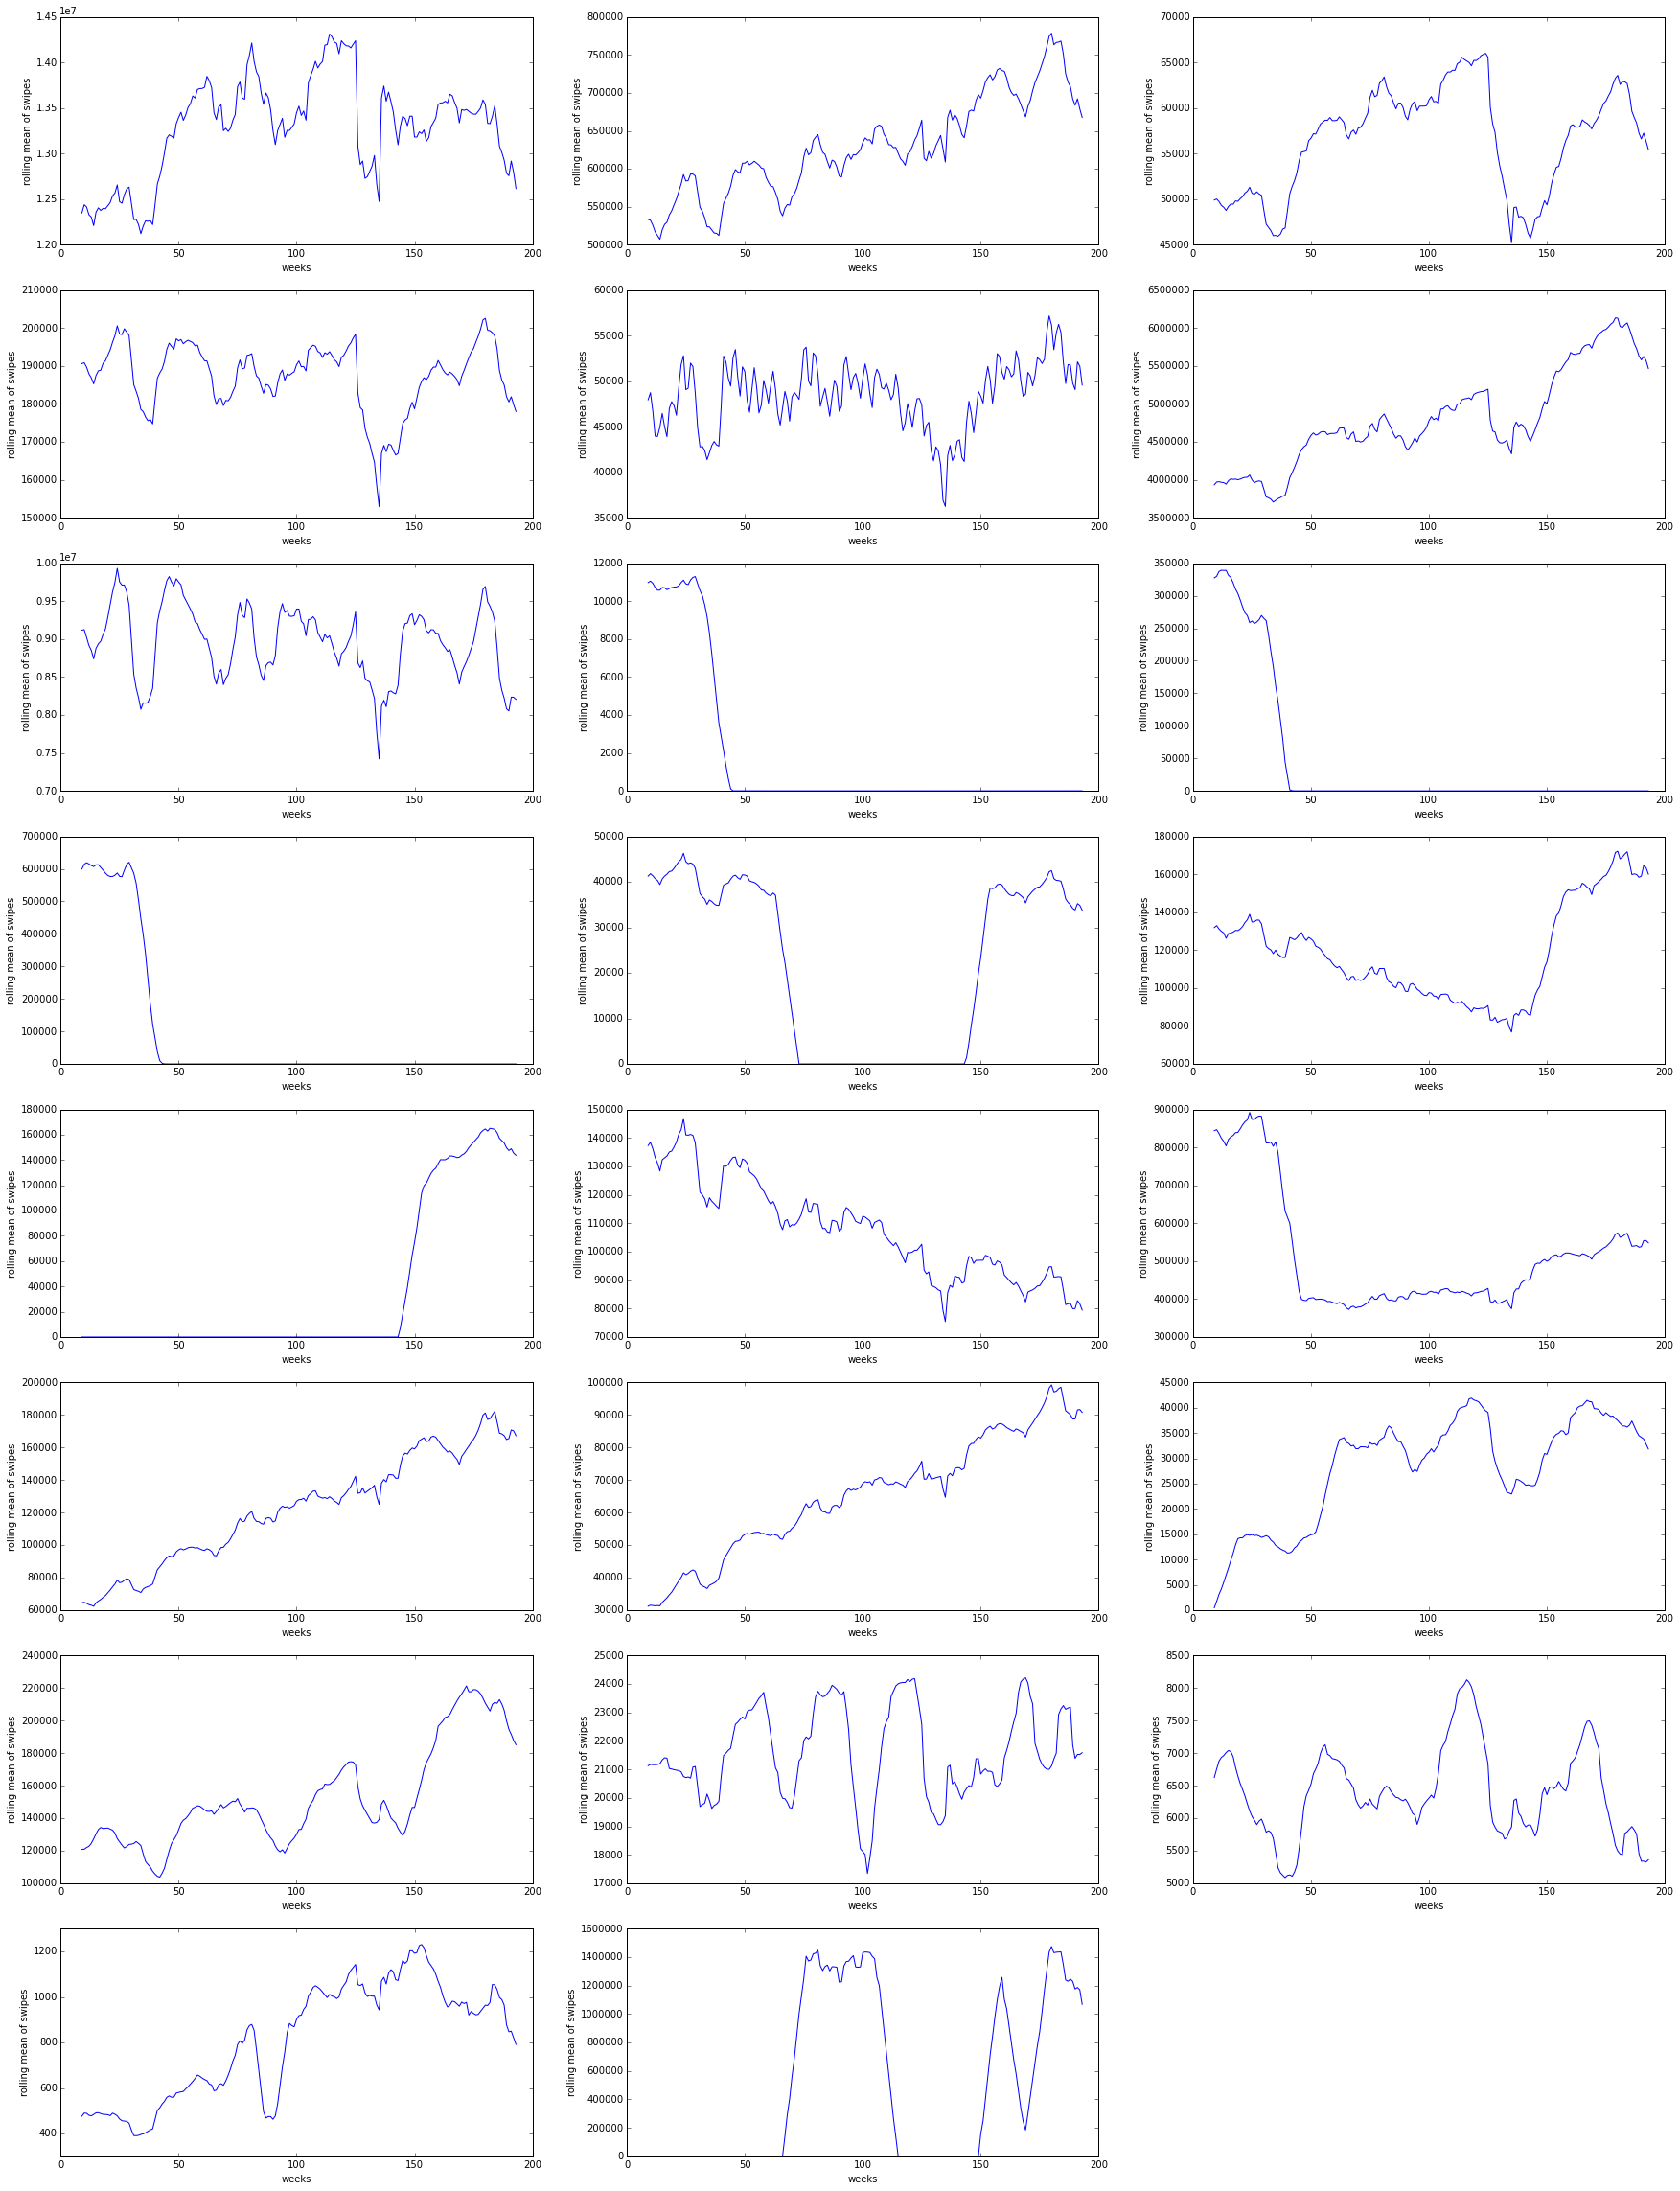

In [47]:
weeks = np.arange(194)
roll_mean = pd.rolling_mean(stadf[stadf.columns[:]], 10)
roll_mean.index = weeks

#roll_mean.plot(figsize=(15,5))

fig = plt.figure(figsize = (30,40))
for i in range(23):
    fig.add_subplot(8,3,i+1)
    plt.plot(weeks, roll_mean.iloc[:,i])
    plt.xlabel("weeks")
    plt.ylabel("rolling mean of swipes")

In [53]:
ratiodf = (roll_mean.iloc[-1]/roll_mean.iloc[9])
print 'Increasing:'
print ratiodf[ratiodf > 1].head(10).sort_values(ascending=0)
print '\nDecreasing:'
print ratiodf[ratiodf < 1].head(10).sort_values(ascending=0)

Increasing:
mr      24784.931034
spec       70.182379
sen         2.909397
rr          2.592960
7d          1.389748
14d         1.252065
mc          1.213541
1d          1.111345
30d         1.033787
10t         1.021798
dtype: float64

Decreasing:
2t       0.933803
ada      0.899841
ff       0.818802
umlim    0.809064
rfm      0.649608
month    0.578722
afas     0.000209
exp      0.000011
ez       0.000002
dtype: float64


### Type: spec, sen, rr, 7d are stabely increasing in popularity.
### Type: month, rfm, unlim are stabely decreasing in popularity.
### The amount of change is shown in the table above. Some unusal values (like values arond 0) and some very large values are due to the fact that those kinds of fare type closed or starteded recently.
***

## Task 3:
### Several stations show a prominent annual periodicity. Identify the 4 **stations** (indentify them by the index of their location in the data cube) that show the most prominent periodic trend on an annual period (52 weeks). (Can you figure out what the periodic peak in rides is due to?)

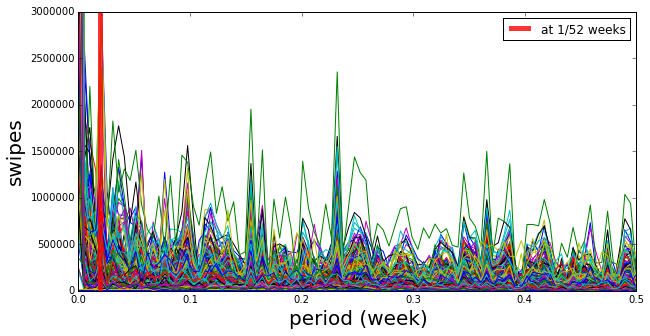

In [63]:
freqdf = pd.DataFrame(mta_allsum_ridetypes)

freq = np.abs(np.fft.rfft(freqdf))
fig = plt.figure(figsize=(10,5))
ax5 = fig.add_subplot(111)
sample_rate = 1
for i in range(600):
    plt.plot(np.fft.rfftfreq(194, 1.0), (freq[i]), '-')

plt.xlabel("period (week)", fontsize=20)
plt.ylabel("swipes", fontsize=20)
plt.ylim([0, 3e6])
plt.axvline(1.0/52,lw=5, color='red', label='at 1/52 weeks',alpha=0.8)
plt.legend()

In [ ]:
freqdf = pd.DataFrame(mta_allsum_ridetypes)

freq = np.abs(np.fft.rfft(freqdf))
fig = plt.figure(figsize=(10,5))
ax5 = fig.add_subplot(111)
sample_rate = 1
for i in range(600):
    plt.plot(np.fft.rfftfreq(194, 1.0), (f[i]), '-')

plt.xlabel("period (week)", fontsize=20)
plt.ylim([0, 3e6])
plt.axvline(1.0/52,lw=5, color='red', label='at 1/52 weeks',alpha=0.8)
plt.legend(loc='best')

In [66]:
exsta = []

for i in range(0,600):
    exsta.append(sorted(freq[i])[96])

staid = []
staid = sorted(exsta)[-4:]
print staid

print "station:", exsta.index(staid[0]), exsta.index(staid[1]), exsta.index(staid[2]), exsta.index(staid[3])

 [2446320.5879031457, 2931895.8769513383, 2950388.929214194, 2980160.6355953491]
station: 56 150 194 0


### Stations 1, 57, 150, 194 show prominent annual periodicities.

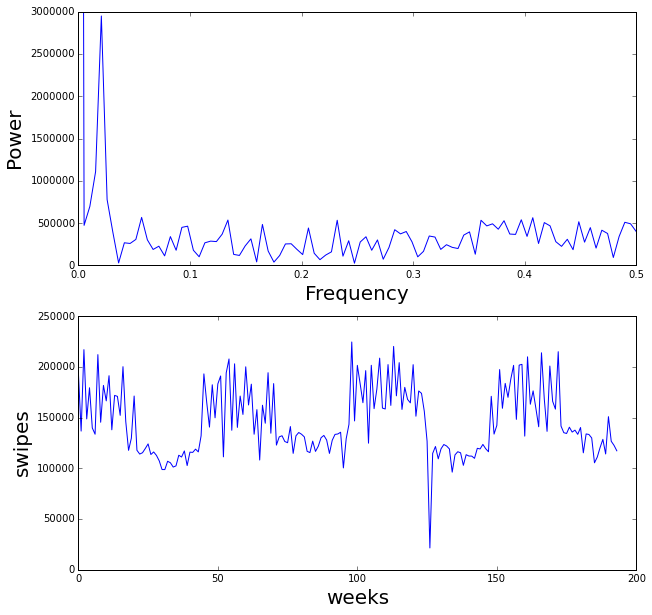

In [69]:
fig=plt.figure(figsize=(10,10))
ax6 = fig.add_subplot(211)
ax6.plot(np.fft.rfftfreq(194, 1.0), (freq[194]), '-', label='station 194')
plt.ylim([0, 3e6])
plt.xlabel('Frequency', fontsize=20)
plt.ylabel('Power', fontsize=20)

ax7 = fig.add_subplot(212)
ax7.plot(freqdf.loc[194], '-', label='station 194')
plt.xlabel('weeks', fontsize=20)
plt.ylabel('swipes', fontsize=20)

### The periodic peaks in rides are shown in the plot above